In [1]:
import numpy as np 


from scipy.integrate import solve_ivp

from pylab import cm
import matplotlib as mpl
import matplotlib.pyplot as plt 

#mpl.style.use('seaborn')

from functools import partial 
from tqdm import tqdm 
 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

tqdm = partial(tqdm, position=0, leave=True)


/home/ai/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def f_translation(x, y): 
    return 0. 

def single_solve(y0): 
    return solve_ivp(f_translation, t_span=[-1, 1], y0=[y0], t_eval=np.linspace(-1., 1., 20))


In [3]:
x, y = np.linspace(-2., 2., 35), np.linspace(-2., 2., 35) 
X, Y = np.meshgrid(x, y) 

dYdX = f_translation(X, Y)
U = (1. / (1. + dYdX**2) ** 0.5) * np.ones(Y.shape) 
V = (1. / (1. + dYdX**2) ** 0.5) * dYdX


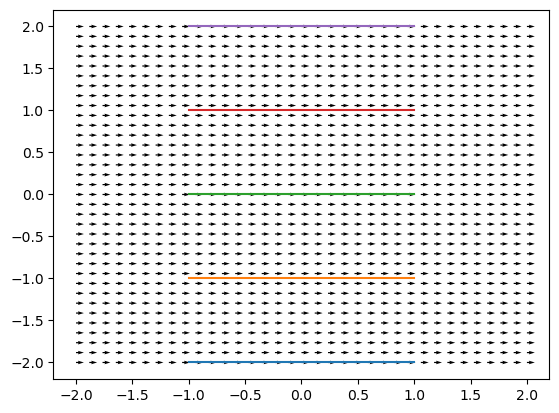

In [4]:
plt.quiver(X, Y, U, V, cmap='coolwarm')

y0s = np.linspace(-2., 2., 5)

for y0 in y0s: 
    res = single_solve(y0) 
    resx, resy = res.t, res.y.flatten() 

    plt.plot(resx, resy)



In [5]:
# accurate 1D shift operator Shannon-Whittaker Interpolation
shift = Q = lambda d,z: np.sum([1/d * np.cos(2*np.pi*p/d *z) for p in np.arange(-d/2+1,d/2)], axis=0)

# generator of 1D translations
L0 = lambda d,z: np.sum([-2*np.pi*p/d**2 * np.sin(2*np.pi*p/d *z) for p in np.arange(-d/2+1,d/2)], axis=0)

# cosine correlation 
coscorr = lambda x,y: np.trace(x.T@y)/np.linalg.norm(x)/np.linalg.norm(y)

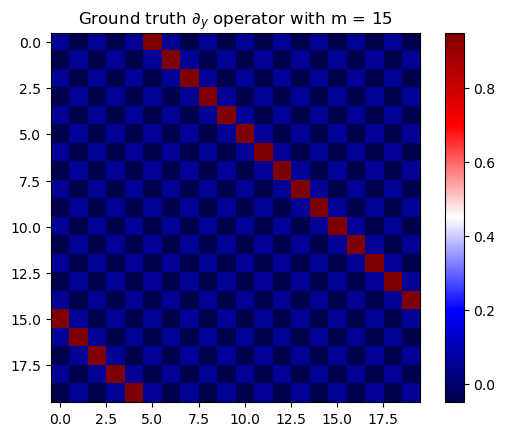

In [6]:
d = 20
m = 15
z = np.arange(d)[:,np.newaxis]-np.arange(d)
plt.imshow(Q(d,z-m), cmap = 'seismic') # vmin=-1, vmax=1
plt.title(fr"Ground truth $\partial_y$ operator with m = {m}")
plt.colorbar()

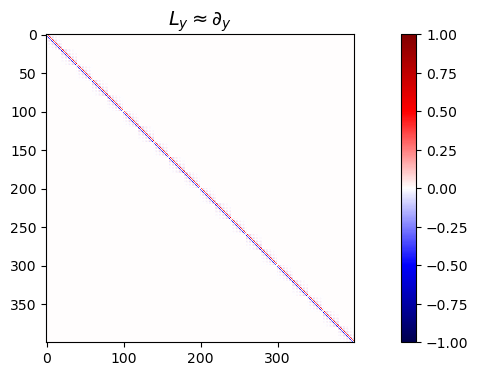

In [7]:
coords = np.mgrid[:d, :d] - d / 2
x, y = coords.reshape((2, -1))
dy = (y[:,np.newaxis]-y) * (x[:,np.newaxis]==x) # ... same x

plt.figure(figsize=(12,4))

Ly = L0(2*d, dy)
plt.imshow(Ly, cmap='seismic', vmin=-1, vmax=1)
plt.colorbar() 
plt.title(r'$L_y\approx \partial_y$',size=14);



In [8]:
DIM = 20 

class FixedTranslation_2D(datasets.VisionDataset):
    def __init__(self, *args, dx = 40, N = 50_000, dataseed=0, dataset, **kwargs):
        super().__init__(*args, **kwargs)

        self.affine_translation_matrix = torch.Tensor([
            1, 0, 0, 
            0, 1, dx / (2 * DIM)  
        ])[None]

        self.data = np.zeros([N, 1, DIM, DIM])

        for i in range(0, N): 
            resy = (np.rint(dataset[i]*9)).astype(int) // 2
            resy = -resy + 9
            for xi in range(0, DIM):
                #print(xi, resy.shape)
                self.data[i][0][resy[xi]][xi] = 1.

        self.data = torch.Tensor(self.data)
        print(N, self.data.shape)

        torch.manual_seed(dataseed) 

        with torch.no_grad(): 
            affineMatrices = torch.zeros(N, 2, 3)
            affineMatrices[:, 0, 0] = 1 
            affineMatrices[:, 1, 1] = 1
            affineMatrices[:, 1, 2] = dx / (2 * DIM)

            flowgrid = F.affine_grid(affineMatrices, size=self.data.shape)

            self.data_translated = F.grid_sample(self.data, flowgrid)

    def __getitem__(self, idx): 
        return self.data[idx], self.data_translated[idx]
    
    def __len__(self): 
        return len(self.data) 


In [9]:
DIM = 20 

class FixedTranslation_1D(datasets.VisionDataset):
    def __init__(self, *args, dx = 40, N = 50_000, dataseed=0, dataset, **kwargs):
        super().__init__(*args, **kwargs)

        self.affine_translation_matrix = torch.Tensor([
            1, 0, 0, 
            0, 1, dx / (2 * DIM)  
        ])[None]

        self.data = np.zeros([N, 1, DIM, DIM])

        for i in range(0, N): 
            resy = (np.rint(dataset[i]*9)).astype(int) // 2
            resy = -resy + 9
            for xi in range(0, DIM):
                #print(xi, resy.shape)
                self.data[i][0][resy[xi]][xi] = 1.

        self.data = torch.Tensor(self.data)
        print(N, self.data.shape)

        torch.manual_seed(dataseed) 

        with torch.no_grad(): 
            affineMatrices = torch.zeros(N, 2, 3)
            affineMatrices[:, 0, 0] = 1 
            affineMatrices[:, 1, 1] = 1
            affineMatrices[:, 1, 2] = dx / (2 * DIM)

            flowgrid = F.affine_grid(affineMatrices, size=self.data.shape)

            self.data_translated = F.grid_sample(self.data, flowgrid)

    def __getitem__(self, idx): 
        return self.data[idx], self.data_translated[idx]
    
    def __len__(self): 
        return len(self.data) 


In [18]:
NSolve = 1_000
rez = np.zeros([NSolve, 20])

y0s = np.linspace(-2., -0.5, NSolve)

for idx, y0 in enumerate(tqdm(y0s)): 
    res = single_solve(y0) 
    resx, resy = res.t, res.y.flatten() 

    rez[idx] = resy

100%|██████████| 1000/1000 [00:00<00:00, 2216.05it/s]


1000 torch.Size([1000, 1, 20, 20])


/home/ai/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/ai/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Text(0.5, 1.0, 'Translated y = c + dx')

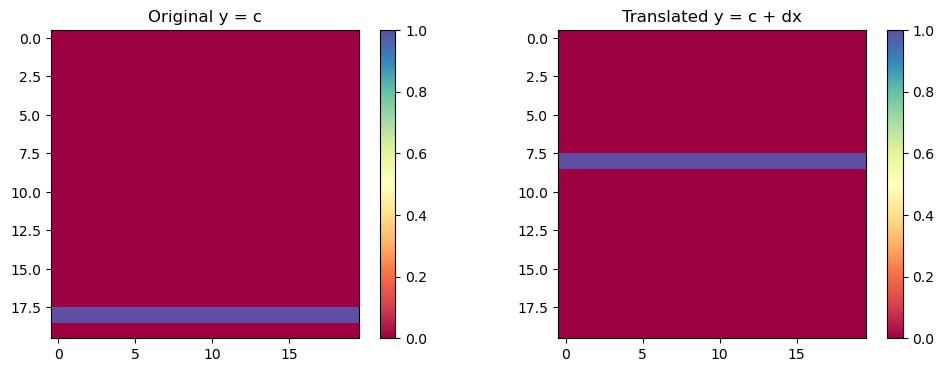

In [19]:
test_translation = FixedTranslation_2D

dx = 40 # 20 
dataset1 = test_translation('../data', dx=dx, N=NSolve, dataset=rez)

data, data_translated = dataset1.__getitem__(7)

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.imshow(data.squeeze(), cmap='Spectral')
plt.colorbar()
plt.title("Original y = c")

plt.subplot(122) 
plt.imshow(data_translated.squeeze(),cmap='Spectral')
plt.colorbar()
plt.title("Translated y = c + dx")



In [20]:
from time import time
class trainer():
    def __init__(self, model, device, optimizer, dataset_class = None, 
                 train_loader=None, test_loader=None,
                 batch_size = 64, test_batch_size = 1000,loss_func = F.nll_loss,
                ):
        """
        usage:
            t = trainer(...)
            t.fit(epochs)
            
        methods:
            .fit(epochs) : train + test; print results; stores results in trainer.history <dict>
            .train(epoch)
            .test()
        """
        self.device = device #torch.device(device)
        self.optimizer = optimizer
        self.model = model
        self.loss_func = loss_func

        self.scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
        self.history = {'train loss':[], 'test loss':[], 'train acc':[], 'test acc':[], 'train time':[]}
        
        if dataset_class:
            self.make_dataloaders(dataset_class, batch_size, test_batch_size)
        else:
            self.train_loader = train_loader 
            self.test_loader = test_loader
        
    def make_dataloaders(self, dataset_class, batch_size, test_batch_size):
        train_kwargs = {'batch_size': batch_size}
        test_kwargs = {'batch_size': test_batch_size}
        if self.device.type =='cuda':        
            cuda_kwargs = {'num_workers': 1,
                           'pin_memory': True,
                           'shuffle': True}
            train_kwargs.update(cuda_kwargs)
            test_kwargs.update(cuda_kwargs)
        
        print('Creating data loaders...',end='')
        dataset1 = dataset_class('../data', train=True, download=True,)
        dataset2 = dataset_class('../data', train=False,)

        self.train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
        self.test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
        print('Done')

#         self.optimizer = optimizer
#         self.model, self.device, self.train_loader,  = model, device, train_loader,
#         self.test_loader = test_loader
        
    def progbar(self,percent, N=10):
        n = int(percent//N)
        return '[' + '='*n + '>' +'.'*(N-n-1) +']'
    
    def train(self,epoch):
        self.model.train()
        training_loss = 0
        correct = 0
        t0 = time()
        for batch_idx, (data, target) in enumerate(self.train_loader):
            if type(data)==list:
                data = [d.to(self.device) for d in data]
            else:
                data = data.to(self.device)
            if type(target)==list:
                target = [d.to(self.device) for d in target]
            else:
                target = target.to(self.device)
                
#             data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.loss_func(output, target)
            training_loss += loss.sum().item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            loss.backward(retain_graph=True)
            self.optimizer.step()
            if batch_idx % 10 == 0:
                perc = 100. * batch_idx / len(self.train_loader)
                t1 = time()
                print('Train Epoch: {} {} {:.1f}s [{}/{} ({:.0f}%)]\tLoss: {:.4g}'.format(
                    epoch, self.progbar(perc), t1-t0,
                    batch_idx * len(data), len(self.train_loader.dataset), # n/N
                    perc, # % passed
                    loss.item()), end='\r')
        
        training_loss /= len(self.train_loader.dataset)
        acc = correct / len(self.train_loader.dataset)    
        print('\nTraining: loss: {:.4g}, Acc: {:.2f}%'.format(training_loss, 100.*acc))
            
        return {'loss':training_loss, 'acc':acc , 'time':t1-t0}
                
        
    def test(self):
        self.model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in self.test_loader:
                if type(data)==list:
                    data = [d.to(self.device) for d in data]
                else:
                    data = data.to(self.device)
                if type(target)==list:
                    target = [d.to(self.device) for d in target]
                else:
                    target = target.to(self.device)
                #data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                test_loss += self.loss_func(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

        
        test_loss /= len(self.test_loader.dataset)
        test_acc = correct / len(self.test_loader.dataset)
        
        print('Test loss: {:.4g}, Test acc.: {:.2f}%'.format( test_loss, 100.*test_acc))
        return {'loss':test_loss, 'acc':test_acc}
    
    def fit(self,epochs=1):
        for epoch in range(1, epochs + 1):
            r = self.train(epoch)
            self.history['train loss'] += [r['loss']]
            self.history['train acc'] += [r['acc']]
            self.history['train time'] += [r['time']]
            
            r = self.test()
            self.history['test loss'] += [r['loss']]
            self.history['test acc'] += [r['acc']]
            self.scheduler.step()

In [21]:
# includes residual
       
class Lconv_core(nn.Module):
    """ L-conv layer with full L """
    def __init__(self,d,num_L=1,cin=1,cout=1,rank=8):
        """
        L:(num_L, d, d)
        Wi: (num_L, cout, cin)
        """
        super().__init__()
        self.L = nn.Parameter(torch.Tensor(num_L, d, d))
        self.Wi = nn.Parameter(torch.Tensor(num_L, cout, cin))
        
        # initialize weights and biases
        nn.init.kaiming_normal_(self.L) 
        nn.init.kaiming_normal_(self.Wi)
                
    def forward(self, x):
        # x:(batch, channel, flat_d)
        # h = (x + Li x Wi) W0
        y = torch.einsum('kdf,bcf,koc->bod', self.L, x, self.Wi ) +x #+ self.b        
        return y


In [22]:
# includes residual

class Lconv_grid(nn.Module):
    """ L-conv using an inferred grid in the data. 
    """
    def __init__(self,idx, k,d,cin,cout):
        super().__init__()
        self.idx = idx
        self.L_sparse = nn.Parameter(torch.Tensor(*idx.shape, k)) 
        self.W = nn.Parameter(torch.Tensor(k, cin, cout))
        self.b = nn.Parameter(torch.Tensor(1, cout, 1))
        # the bias is not complete, but more efficient 
#         self.b = nn.Parameter(torch.Tensor(1,k, cout, 1))
        
        # initialize weights and biases
        nn.init.kaiming_normal_(self.L_sparse, mode='fan_in') 
        nn.init.kaiming_normal_(self.W)      
        nn.init.kaiming_normal_(self.b)
                
    def forward(self, x):
        # x:(batch, channel, flat_d)
        return torch.einsum('bcdi,dik,kco->bod',x[:,:,self.idx], self.L_sparse, self.W ) + self.b


In [23]:
class Reshape(nn.Module):
    def __init__(self,shape=None):
        self.shape = shape
        super().__init__()
    def forward(self,x):
        return x.view(-1,*self.shape)

In [24]:

# dataset = CIFAR100
dataset = FixedTranslation_2D #AugRotMNIST__0
# dataset = AugRotMNIST__0

batch_size = 32

test_batch_size = 1000 #150
device = torch.device("cuda")
# device = torch.device("cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
# if use_cuda:
cuda_kwargs = {'num_workers': 1,
               'pin_memory': True,
               'shuffle': True}
train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)

dataset1 = test_translation('../data', dx=dx, N=NSolve, dataset=rez)


dataset1 = dataset('../data', dx=dx, dataset=rez, N=NSolve)
dataset2 = dataset('../data', dx=dx, dataset=rez, N=NSolve)

train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)


1000 torch.Size([1000, 1, 20, 20])
1000 torch.Size([1000, 1, 20, 20])
1000 torch.Size([1000, 1, 20, 20])


In [25]:
s = dataset1[0][0].shape 
d = np.prod(s) 
lc = Lconv_core(d=d, num_L=1, cin=1, cout=1)


model = nn.Sequential(
    nn.Flatten(2),
    lc,
    Reshape(s)
).to(device)
optimizer = optim.Adam(model.parameters(),lr = 5e-3)

t = trainer(model, device, optimizer, train_loader=train_loader, test_loader=test_loader, 
            #dataset_class=AugRotMNIST__0, #dataset, 
            loss_func=F.mse_loss)
t.fit(20)



Train Epoch: 1 [=========>] 0.6s [960/1000 (94%)]	Loss: 0.0004215
Training: loss: 0.00108, Acc: 38000.00%
Test loss: 0.4213, Test acc.: 38000.00%
Train Epoch: 2 [=========>] 0.1s [960/1000 (94%)]	Loss: 5.638e-05
Training: loss: 3.642e-05, Acc: 38000.00%
Test loss: 0.06944, Test acc.: 38000.00%
Train Epoch: 3 [=========>] 0.1s [960/1000 (94%)]	Loss: 1.699e-06
Training: loss: 2.546e-06, Acc: 38000.00%
Test loss: 0.01449, Test acc.: 38000.00%
Train Epoch: 4 [=========>] 0.1s [960/1000 (94%)]	Loss: 3.77e-087
Training: loss: 1.026e-06, Acc: 38000.00%
Test loss: 0.01164, Test acc.: 38000.00%
Train Epoch: 5 [=========>] 0.1s [960/1000 (94%)]	Loss: 3.991e-09
Training: loss: 8.788e-07, Acc: 38000.00%
Test loss: 0.0107, Test acc.: 38000.00%
Train Epoch: 6 [=========>] 0.1s [960/1000 (94%)]	Loss: 1.901e-09
Training: loss: 8.148e-07, Acc: 38000.00%
Test loss: 0.01012, Test acc.: 38000.00%
Train Epoch: 7 [=========>] 0.1s [960/1000 (94%)]	Loss: 2.243e-09
Training: loss: 7.746e-07, Acc: 38000.00%
Te

Text(0.5, 0, 'Epochs')

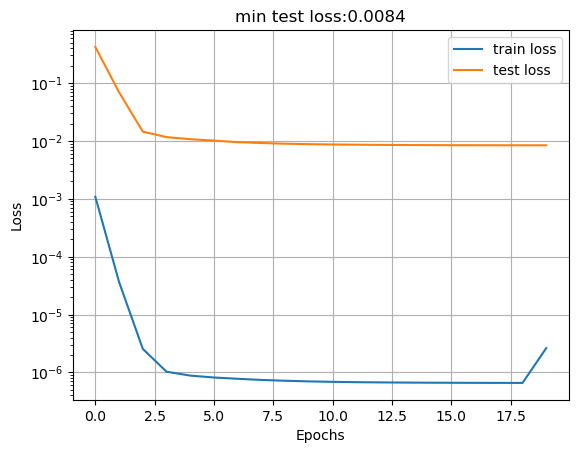

In [26]:
for k in ['train loss', 'test loss']:
    plt.plot(t.history[k], label=k)
    
plt.title(f'min test loss:{min(t.history["test loss"]):.3g}')
plt.legend()
plt.grid()
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')

In [30]:
L_translate = (lc.L*lc.Wi).detach().cpu().numpy() * dx
lc.Wi

Parameter containing:
tensor([[[-0.4155]]], device='cuda:0', requires_grad=True)

In [31]:
(lc.L*lc.Wi).detach().cpu().numpy().shape

(1, 400, 400)

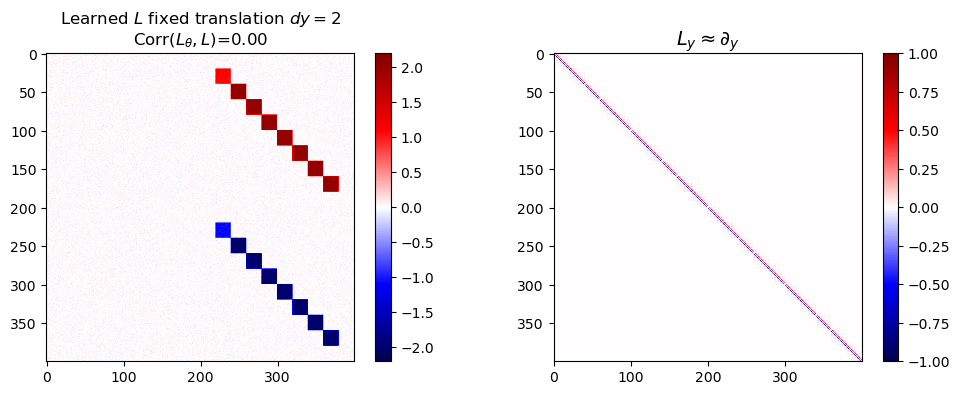

In [32]:
layer_idx = 0

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(L_translate[layer_idx], cmap='seismic')

plt.title(r"Learned $L$ fixed translation $dy = 2$" + \
      '\n'+r'Corr($L_\theta,L$)=%.2f'% coscorr(L_translate[layer_idx], Ly))

plt.colorbar()  

plt.subplot(122)
plt.imshow(Ly, cmap='seismic', vmin=-1, vmax=1)

plt.title(r'$L_y\approx \partial_y$',size=14);

plt.colorbar()  
